In [1]:
%load_ext autoreload
%autoreload 2
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

import jax
import torchvision
import numpy as np 
import seaborn as sns
import jax.numpy as jnp
from einops import rearrange
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import ImageGrid

%cd ..
from src import *

import imageio
import equinox as eqx

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform
/home/phamb/work/diffusion-jax


In [2]:
FOLDER = "./cifar10_unet_pred_v" + '/ckpts'
ckpt_manager = create_checkpoint_manager(FOLDER)
model_dict = restore_model(ckpt_manager)

model_dict['params'].keys()

dict_keys(['down_0.attnblock_0', 'down_0.downsample_0', 'down_0.resblock_0', 'down_0.resblock_1', 'down_1.attnblock_0', 'down_1.downsample_0', 'down_1.resblock_0', 'down_1.resblock_1', 'down_2.attnblock_0', 'down_2.downsample_0', 'down_2.resblock_0', 'down_2.resblock_1', 'down_3.attnblock_0', 'down_3.conv_0', 'down_3.resblock_0', 'down_3.resblock_1', 'final.conv_0', 'final.resblock_0', 'init.conv_0', 'mid.attenblock_0', 'mid.resblock_0', 'mid.resblock_1', 'time_mlp.dense_0', 'time_mlp.dense_1', 'up_0.attnblock_0', 'up_0.conv_0', 'up_0.resblock_0', 'up_0.resblock_1', 'up_1.attnblock_0', 'up_1.resblock_0', 'up_1.resblock_1', 'up_1.upsample_0', 'up_2.attnblock_0', 'up_2.resblock_0', 'up_2.resblock_1', 'up_2.upsample_0', 'up_3.attnblock_0', 'up_3.resblock_0', 'up_3.resblock_1', 'up_3.upsample_0'])

In [3]:
config = model_dict['config']

model = Unet(
    dim=config["dim"],
    init_dim=config["init_dim"],
    out_dim=config["out_dim"],
    dim_mults=config["dim_mults"],
    resnet_block_groups=config["resnet_block_groups"],
    learned_variance=config["learned_variance"],
)

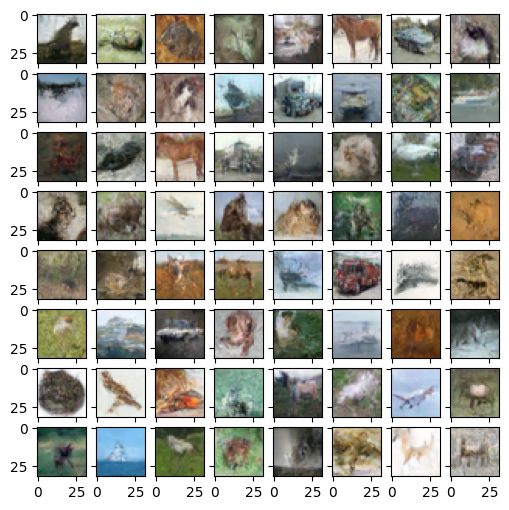

In [4]:
x = np.random.normal(0, 1, size=[64, 32, 32, 3])

timesteps = config['timesteps']
sampling_steps = config['sampling_steps']

pred_fn = get_pred_fn(model_dict['config']['loss_type'])

time_pairs = get_time_pairs(timesteps, sampling_steps)

key = model_dict['config']['key']
key, _ = jax.random.split(key)

x_ddim, x_over_time = eqx.filter_jit(ddim_sample_visual)(
    model_dict['ema_params'],
    model.apply,
    pred_fn,
    x,
    time_pairs,
    key,
    model_dict['config']['var_params'],
    steps = sampling_steps,
    eta = 0.0, 
)

x_ddim = unnormalize_to_zero_to_one(x_ddim)
x_over_time = unnormalize_to_zero_to_one(x_over_time)

x_over_time = x_over_time.at[-1].set(x_ddim)

img = x_ddim

fig = plt.figure(figsize=(6., 6.))

n = int(x.shape[0] ** 0.5)
grid = ImageGrid(fig, 
                 111,
                 nrows_ncols=(n, n),  
                 axes_pad=0.1,
                )

for ax, im in zip(grid, np.split(img, np.arange(1, img.shape[0]), axis = 0)):
    ax.imshow(im.squeeze())
plt.show()

In [7]:
create_gifs(x_over_time, folder = './images/cifar10/', image_size=(128, 128, 3), num_images=1, fps=50000, duration=None)